In [20]:
import torch
import os
from pathlib import Path
import os
import numpy as np
from tqdm import tqdm
from PIL import Image
import glob
from ultralytics import YOLO
import yaml
import matplotlib.pyplot as plt

In [21]:
# model_path = "/Users/jaydenma/Documents/mathematical image analysis/mia final project/models/yolo11m_car1/weights/best.pt"
# train_data_path = "/Users/jaydenma/Documents/mathematical image analysis/mia final project/car detection/train/images"
# train_labels_path = "/Users/jaydenma/Documents/mathematical image analysis/mia final project/car detection/train/labels"
test_data_path = "/Users/jaydenma/Documents/mathematical image analysis/mia final project/data/car detection/test/images"
test_labels_path = "/Users/jaydenma/Documents/mathematical image analysis/mia final project/data/car detection/test/labels"
# data_yaml_path = "/Users/jaydenma/Documents/mathematical image analysis/mia final project/car detection/data.yaml"

# model_path = "/Users/jaydenma/Documents/mathematical image analysis/mia final project/models/yolo11m_carsubset1/weights/best.pt" # control model
# model_path = "/Users/jaydenma/Documents/mathematical image analysis/mia final project/models/yolo11m_carsubset_augmented1/weights/best.pt" # augmented model
model_path = "/Users/jaydenma/Documents/mathematical image analysis/mia final project/models/yolo11m_carsubset_augmented2/weights/best.pt" # augmented model with augmented validation
train_data_path = "/Users/jaydenma/Documents/mathematical image analysis/mia final project/data/car detection subset/train/images"
train_labels_path = "/Users/jaydenma/Documents/mathematical image analysis/mia final project/data/car detection subset/train/labels"
# test_data_path = "/Users/jaydenma/Documents/mathematical image analysis/mia final project/car detection subset/test/images"
# test_labels_path = "/Users/jaydenma/Documents/mathematical image analysis/mia final project/car detection subset/test/labels"
data_yaml_path = "/Users/jaydenma/Documents/mathematical image analysis/mia final project/data/car detection subset/data.yaml"

## load YOLO model

In [22]:
# Load the YOLO model using the model_path variable that's already defined
model = YOLO(model_path)
print(f"Model loaded from: {model_path}")
# print(f"Model version: {model.model.version}")
print(f"Model task: {model.task}")

Model loaded from: /Users/jaydenma/Documents/mathematical image analysis/mia final project/models/yolo11m_carsubset_augmented2/weights/best.pt
Model task: detect



0: 640x640 1 Ambulance, 109.0ms
Speed: 1.2ms preprocess, 109.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


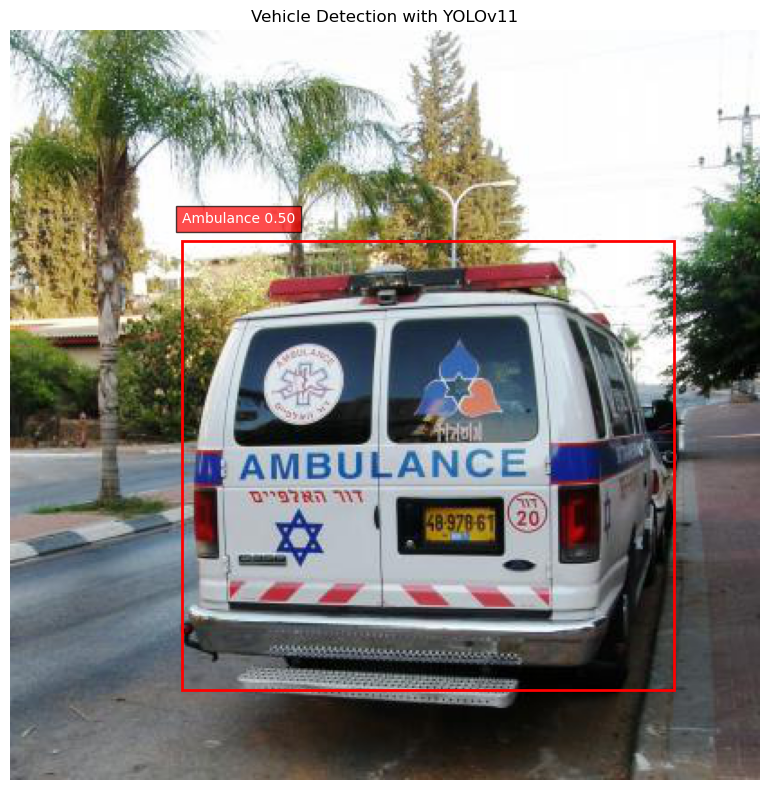

Detections:
- Ambulance: 0.4987


In [23]:
# Load an example motorcycle image and run detection
image_path = "/Users/jaydenma/Documents/mathematical image analysis/mia final project/data/car detection subset/test/images/00dea1edf14f09ab_jpg.rf.dca5c2fe7b2ccb5febe752c01b0c757f.jpg"

# Check if file exists
if os.path.exists(image_path):
    # Load the image
    motorcycle_img = Image.open(image_path)
    
    # Run detection with the loaded model
    results = model(motorcycle_img)
    
    # Plot the results with bounding boxes and labels
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    ax.imshow(motorcycle_img)
    
    # Process detection results
    if len(results) > 0 and hasattr(results[0], 'boxes'):
        boxes = results[0].boxes
        
        for i, box in enumerate(boxes):
            # Get the confidence score
            conf = float(box.conf)
            # Get the class id and name
            cls_id = int(box.cls)
            cls_name = results[0].names[cls_id]
            # Get coordinates
            coords = box.xyxy.tolist()[0] if hasattr(box.xyxy, 'tolist') else box.xyxy[0].tolist()
            
            # Only show predictions with confidence > 0.25
            if conf > 0.25:
                # Get box coordinates
                x1, y1, x2, y2 = coords
                
                # Draw rectangle
                rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='red', linewidth=2)
                ax.add_patch(rect)
                
                # Add label
                ax.text(x1, y1-10, f"{cls_name} {conf:.2f}", color='white', 
                        bbox=dict(facecolor='red', alpha=0.7), fontsize=10)
    
    plt.title("Vehicle Detection with YOLOv11")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Print detection details
    print("Detections:")
    for i, box in enumerate(results[0].boxes):
        conf = float(box.conf)
        cls_id = int(box.cls)
        cls_name = results[0].names[cls_id]
        
        if conf > 0.25:
            print(f"- {cls_name}: {conf:.4f}")
else:
    print(f"Error: Image file not found at {image_path}")
    print("Please update the path to your image.")

## get accuracy

### Load class mapping and helper functions

In [24]:
# Load class names from the YAML file
# data_yaml_path = '/Users/jaydenma/Documents/mathematical image analysis/mia final project/car detection/data.yaml'
with open(data_yaml_path, 'r') as f:
    data_config = yaml.safe_load(f)

class_names = data_config['names']
print(f"Class names: {class_names}")

# Function to read ground truth labels
def read_label_file(label_path):
    """Read YOLO format label file and return list of objects with class and bounding box"""
    gt_objects = []
    try:
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) == 5:  # class, x_center, y_center, width, height
                    class_id = int(parts[0])
                    gt_objects.append({
                        'class_id': class_id,
                        'class_name': class_names[class_id] if class_id < len(class_names) else f"Unknown_{class_id}"
                    })
    except Exception as e:
        print(f"Error reading label file {label_path}: {e}")
    return gt_objects

# Function to compute class-based accuracy
def compute_class_accuracy(predicted_classes, gt_classes):
    """Compute accuracy metrics per class"""
    # Initialize counters for each class
    class_metrics = {name: {'TP': 0, 'FP': 0, 'FN': 0} for name in class_names}
    
    # Convert lists to sets for easier comparison
    pred_set = set(predicted_classes)
    gt_set = set(gt_classes)
    
    # Count true positives, false positives, and false negatives
    for cls in class_names:
        if cls in pred_set and cls in gt_set:
            class_metrics[cls]['TP'] += 1  # True positive
        elif cls in pred_set and cls not in gt_set:
            class_metrics[cls]['FP'] += 1  # False positive
        elif cls not in pred_set and cls in gt_set:
            class_metrics[cls]['FN'] += 1  # False negative
    
    return class_metrics

Class names: ['Ambulance', 'Bus', 'Car', 'Motorcycle', 'Truck']


### Evaluate on original test images

In [25]:
def evaluate_precision_at_threshold(model, test_images_path, ground_truth_path, class_names, confidence_threshold=0.25):
    """
    Evaluate model precision at a specified confidence threshold.
    
    Args:
        model: YOLO model to evaluate
        test_images_path: Path to the directory containing test images
        ground_truth_path: Path to the directory containing ground truth labels
        class_names: List of class names
        confidence_threshold: Confidence threshold for predictions (default: 0.25)
        
    Returns:
        tuple: (class_precision, macro_precision) where:
            - class_precision is a dictionary mapping class names to precision values
            - macro_precision is the average precision across all classes
    """
    # Create dictionaries to store metrics
    overall_metrics = {name: {'TP': 0, 'FP': 0, 'FN': 0} for name in class_names}
    
    # Process each image in the test directory
    for img_path in glob.glob(os.path.join(test_images_path, '*.jpg')) + glob.glob(os.path.join(test_images_path, '*.png')):
        try:
            # Load image
            img = Image.open(img_path)
            img_filename = os.path.basename(img_path)
            base_name = os.path.splitext(img_filename)[0]
            
            # Get corresponding label file path
            label_path = os.path.join(ground_truth_path, base_name + '.txt')
            
            # Load ground truth data
            gt_objects = read_label_file(label_path)
            gt_classes = [obj['class_name'] for obj in gt_objects]
            
            # Run inference
            prediction = model(img)
            
            # Process predictions
            predicted_classes = []
            
            if len(prediction) > 0 and hasattr(prediction[0], 'boxes'):
                boxes = prediction[0].boxes
                
                # Extract class information from predictions
                for box in boxes:
                    # Get the confidence score
                    conf = float(box.conf)
                    # Get the class id and name
                    cls_id = int(box.cls)
                    cls_name = prediction[0].names[cls_id]
                    
                    # Only include predictions above the specified confidence threshold
                    if conf > confidence_threshold:
                        predicted_classes.append(cls_name)
            
            # Compute class-based accuracy for this image
            image_metrics = compute_class_accuracy(predicted_classes, gt_classes)
            
            # Update overall metrics
            for cls in class_names:
                overall_metrics[cls]['TP'] += image_metrics[cls]['TP']
                overall_metrics[cls]['FP'] += image_metrics[cls]['FP']
                overall_metrics[cls]['FN'] += image_metrics[cls]['FN']
            
        except Exception:
            # Silently continue if there's an error with an image
            pass
    
    # Calculate precision for each class
    class_precision = {}
    for cls in class_names:
        tp = overall_metrics[cls]['TP']
        fp = overall_metrics[cls]['FP']
        
        # Calculate precision
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        class_precision[cls] = precision
    
    # Calculate macro-averaged precision
    macro_precision = sum(class_precision.values()) / len(class_precision)
    
    return class_precision, macro_precision

In [26]:

precision = evaluate_precision_at_threshold(model, test_data_path, test_labels_path, class_names, confidence_threshold=0.25)
print("\nPrecision at 0.25 confidence threshold:")
print("{:<15} {:<10}".format("Class", "Precision"))
for cls, prec in precision[0].items():
    print("{:<15} {:<10.2f}".format(cls, prec))
print("\nMacro-averaged precision:")
print(f"{precision[1]:.4f}")


0: 640x640 1 Car, 91.5ms
Speed: 1.5ms preprocess, 91.5ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Car, 85.8ms
Speed: 1.1ms preprocess, 85.8ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Ambulance, 84.0ms
Speed: 0.9ms preprocess, 84.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 Buss, 2 Cars, 83.7ms
Speed: 1.0ms preprocess, 83.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Motorcycle, 88.1ms
Speed: 0.9ms preprocess, 88.1ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 Cars, 92.0ms
Speed: 1.0ms preprocess, 92.0ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Truck, 102.2ms
Speed: 1.3ms preprocess, 102.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 93.0ms
Speed: 1.1ms preprocess, 93.0ms inference, 0.2ms postprocess per image at sh

## Evaluate precision at different confidence thresholds

In [27]:
# Define confidence thresholds to evaluate
confidence_thresholds = [0.1, 0.25, 0.5, 0.75, 0.9]

# Dictionary to store results
threshold_results = {}

# Evaluate precision for each confidence threshold
for threshold in tqdm(confidence_thresholds, desc="Evaluating thresholds"):
    class_precision, macro_precision = evaluate_precision_at_threshold(
        model, test_data_path, test_labels_path, class_names, confidence_threshold=threshold
    )
    
    # Store results
    threshold_results[threshold] = {
        'class_precision': class_precision,
        'macro_precision': macro_precision
    }
    
    # Print current results
    print(f"\nPrecision at {threshold:.2f} confidence threshold:")
    print(f"Macro-averaged precision: {macro_precision:.4f}")

Evaluating thresholds:   0%|          | 0/5 [00:00<?, ?it/s]


0: 640x640 1 Car, 108.9ms
Speed: 1.5ms preprocess, 108.9ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Car, 91.0ms
Speed: 1.0ms preprocess, 91.0ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Ambulance, 85.2ms
Speed: 1.0ms preprocess, 85.2ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 Buss, 2 Cars, 88.7ms
Speed: 1.1ms preprocess, 88.7ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Motorcycle, 86.2ms
Speed: 1.3ms preprocess, 86.2ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 Cars, 84.0ms
Speed: 1.0ms preprocess, 84.0ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Truck, 82.8ms
Speed: 1.0ms preprocess, 82.8ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 84.0ms
Speed: 0.9ms preprocess, 84.0ms inference, 0.2ms postprocess per image at sh

Evaluating thresholds:  20%|██        | 1/5 [00:05<00:23,  5.89s/it]


Precision at 0.10 confidence threshold:
Macro-averaged precision: 0.7653

0: 640x640 1 Car, 90.3ms
Speed: 1.3ms preprocess, 90.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Car, 87.9ms
Speed: 1.0ms preprocess, 87.9ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Ambulance, 88.1ms
Speed: 1.0ms preprocess, 88.1ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 Buss, 2 Cars, 90.1ms
Speed: 1.0ms preprocess, 90.1ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Motorcycle, 90.1ms
Speed: 1.0ms preprocess, 90.1ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 Cars, 107.7ms
Speed: 1.3ms preprocess, 107.7ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Truck, 89.3ms
Speed: 1.3ms preprocess, 89.3ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 88.5ms
Sp

Evaluating thresholds:  40%|████      | 2/5 [00:11<00:17,  5.91s/it]


Precision at 0.25 confidence threshold:
Macro-averaged precision: 0.7653

0: 640x640 1 Car, 87.3ms
Speed: 1.0ms preprocess, 87.3ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Car, 85.7ms
Speed: 1.0ms preprocess, 85.7ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Ambulance, 86.5ms
Speed: 1.0ms preprocess, 86.5ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 Buss, 2 Cars, 87.5ms
Speed: 1.0ms preprocess, 87.5ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Motorcycle, 88.5ms
Speed: 1.0ms preprocess, 88.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 Cars, 87.6ms
Speed: 1.0ms preprocess, 87.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Truck, 87.9ms
Speed: 0.9ms preprocess, 87.9ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 86.3ms
Spee

Evaluating thresholds:  60%|██████    | 3/5 [00:17<00:11,  5.88s/it]


Precision at 0.50 confidence threshold:
Macro-averaged precision: 0.7767

0: 640x640 1 Car, 92.9ms
Speed: 1.0ms preprocess, 92.9ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Car, 93.2ms
Speed: 1.0ms preprocess, 93.2ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Ambulance, 90.2ms
Speed: 1.0ms preprocess, 90.2ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 Buss, 2 Cars, 92.3ms
Speed: 1.1ms preprocess, 92.3ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Motorcycle, 90.9ms
Speed: 1.0ms preprocess, 90.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 Cars, 89.1ms
Speed: 1.0ms preprocess, 89.1ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Truck, 90.9ms
Speed: 1.0ms preprocess, 90.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 89.6ms
Spee

Evaluating thresholds:  80%|████████  | 4/5 [00:23<00:05,  5.89s/it]


Precision at 0.75 confidence threshold:
Macro-averaged precision: 0.7676

0: 640x640 1 Car, 90.5ms
Speed: 1.3ms preprocess, 90.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Car, 87.9ms
Speed: 1.1ms preprocess, 87.9ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Ambulance, 86.9ms
Speed: 0.9ms preprocess, 86.9ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 Buss, 2 Cars, 87.1ms
Speed: 1.0ms preprocess, 87.1ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Motorcycle, 85.8ms
Speed: 1.0ms preprocess, 85.8ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 Cars, 86.3ms
Speed: 1.0ms preprocess, 86.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Truck, 86.4ms
Speed: 1.0ms preprocess, 86.4ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 105.6ms
Spe

Evaluating thresholds: 100%|██████████| 5/5 [00:29<00:00,  5.88s/it]


Precision at 0.90 confidence threshold:
Macro-averaged precision: 0.7225


## Visualize relationship between confidence threshold and precision

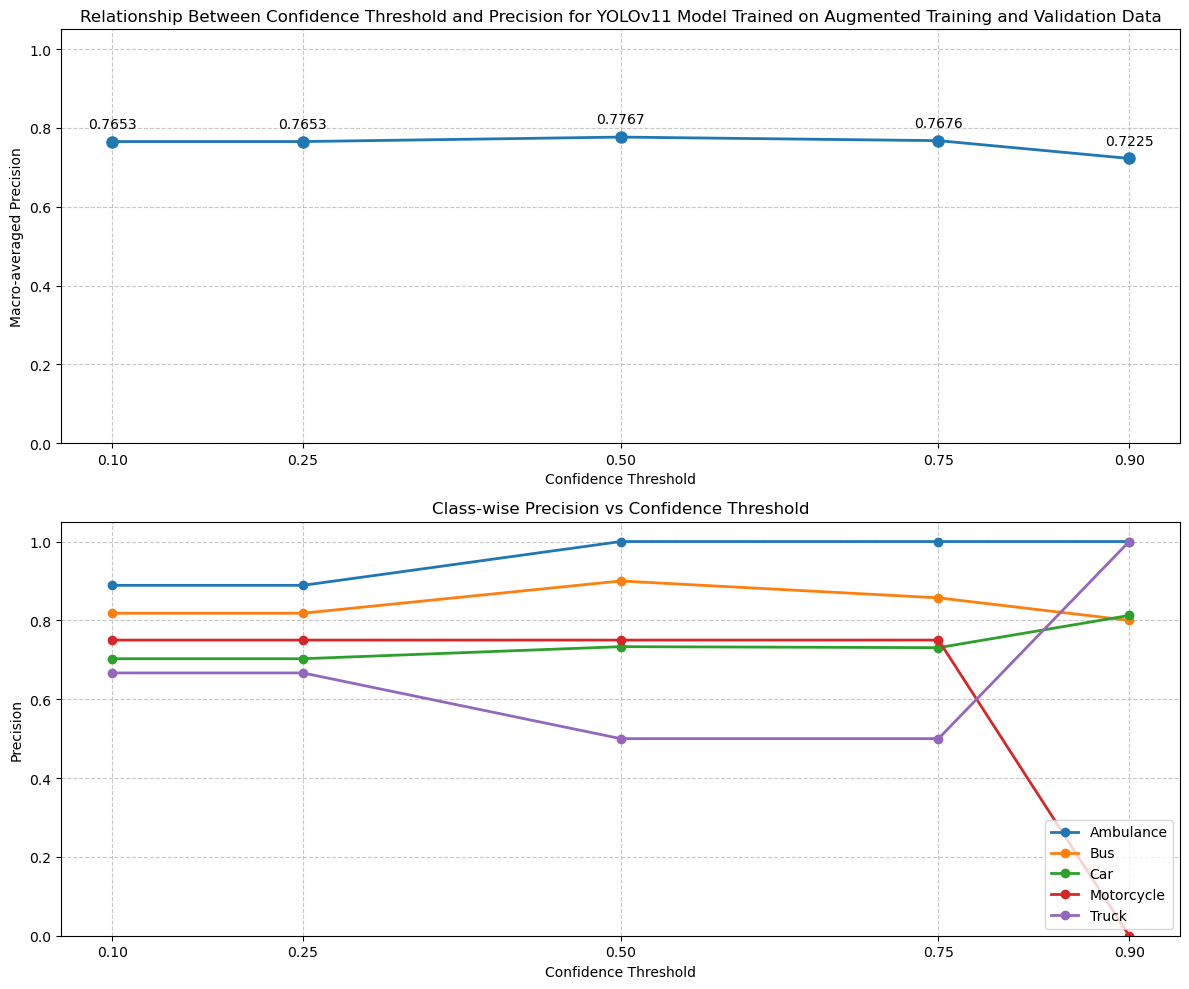


Precision Values by Class and Confidence Threshold:
Class        Conf 0.1   Conf 0.2   Conf 0.5   Conf 0.8   Conf 0.9  
--------------------------------------------------------------
Ambulance    0.8889     0.8889     1.0000     1.0000     1.0000    
Bus          0.8182     0.8182     0.9000     0.8571     0.8000    
Car          0.7027     0.7027     0.7333     0.7308     0.8125    
Motorcycle   0.7500     0.7500     0.7500     0.7500     0.0000    
Truck        0.6667     0.6667     0.5000     0.5000     1.0000    
--------------------------------------------------------------
Macro-avg    0.7653     0.7653     0.7767     0.7676     0.7225    


In [31]:
# Extract threshold and precision values for plotting
thresholds = list(threshold_results.keys())
macro_precisions = [result['macro_precision'] for result in threshold_results.values()]

# Set up the figure for plotting
plt.figure(figsize=(12, 10))

# Plot 1: Overall macro-precision vs confidence threshold
plt.subplot(2, 1, 1)
plt.plot(thresholds, macro_precisions, 'o-', linewidth=2, markersize=8)
plt.xlabel('Confidence Threshold')
plt.ylabel('Macro-averaged Precision')
plt.title('Relationship Between Confidence Threshold and Precision for YOLOv11 Model Trained on Augmented Training and Validation Data')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(thresholds)
plt.ylim([0, 1.05])

# Annotate points with precision values
for i, precision in enumerate(macro_precisions):
    plt.annotate(f"{precision:.4f}", 
                 (thresholds[i], precision),
                 textcoords="offset points", 
                 xytext=(0,10), 
                 ha='center')

# Plot 2: Class-wise precision vs confidence threshold
plt.subplot(2, 1, 2)

# Extract class-wise precision for each threshold
class_precisions = {}
for cls in class_names:
    class_precisions[cls] = [result['class_precision'][cls] for result in threshold_results.values()]
    plt.plot(thresholds, class_precisions[cls], 'o-', linewidth=2, label=cls)

plt.xlabel('Confidence Threshold')
plt.ylabel('Precision')
plt.title('Class-wise Precision vs Confidence Threshold')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(thresholds)
plt.ylim([0, 1.05])
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

# Create a table showing the precision values for each class and threshold
print("\nPrecision Values by Class and Confidence Threshold:")
print("{:<12} {:<10} {:<10} {:<10} {:<10} {:<10}".format(
    "Class", *[f"Conf {t:.1f}" for t in thresholds]))
print("-" * 62)

for cls in class_names:
    print("{:<12} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f}".format(
        cls, *class_precisions[cls]))

print("-" * 62)
print("{:<12} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f}".format(
    "Macro-avg", *macro_precisions))

## Testing augmented images

In [29]:
# Define the path for augmented test images
augmented_test_path = '/Users/jaydenma/Documents/mathematical image analysis/mia final project/car detection/test/images_augmented'

# Create lists to store results
augmented_results = []
augmented_total_images = 0
augmented_overall_metrics = {name: {'TP': 0, 'FP': 0, 'FN': 0} for name in class_names}

# Get mapping from augmented filename to original filename for ground truth lookup
def get_original_filename(aug_filename):
    # Augmented files typically have format: original_name_filter.ext
    parts = os.path.splitext(aug_filename)[0].split('_')
    # Remove the filter suffix to get original name
    original_name = '_'.join(parts[:-1]) if len(parts) > 1 else parts[0]
    return original_name

# Process each image in the augmented test directory
for img_path in tqdm(glob.glob(os.path.join(augmented_test_path, '*.jpg')) + 
                     glob.glob(os.path.join(augmented_test_path, '*.png'))):
    try:
        # Load image
        img = Image.open(img_path)
        img_filename = os.path.basename(img_path)
        
        # Get original filename to find corresponding label
        original_base = get_original_filename(img_filename)
        label_path = os.path.join(ground_truth_path, original_base + '.txt')
        
        # Load ground truth data
        gt_objects = read_label_file(label_path)
        gt_classes = [obj['class_name'] for obj in gt_objects]
        
        # Run inference
        prediction = model(img)
        
        # Process predictions
        predicted_classes = []
        detections = []
        
        if len(prediction) > 0 and hasattr(prediction[0], 'boxes'):
            boxes = prediction[0].boxes
            
            # Extract class information from predictions
            for i, box in enumerate(boxes):
                # Get the confidence score
                conf = float(box.conf)
                # Get the class id and name
                cls_id = int(box.cls)
                cls_name = prediction[0].names[cls_id]
                # Get coordinates
                coords = box.xyxy.tolist()[0] if hasattr(box.xyxy, 'tolist') else box.xyxy[0].tolist()
                
                # Only include predictions with confidence > 0.25
                if conf > 0.25:
                    predicted_classes.append(cls_name)
                    detections.append({
                        'confidence': conf,
                        'class_id': cls_id,
                        'class_name': cls_name,
                        'box': coords
                    })
        
        # Compute class-based accuracy for this image
        image_metrics = compute_class_accuracy(predicted_classes, gt_classes)
        
        # Update overall metrics
        for cls in class_names:
            augmented_overall_metrics[cls]['TP'] += image_metrics[cls]['TP']
            augmented_overall_metrics[cls]['FP'] += image_metrics[cls]['FP']
            augmented_overall_metrics[cls]['FN'] += image_metrics[cls]['FN']
        
        # Store the result for this image
        augmented_results.append({
            'image_path': img_path,
            'ground_truth': gt_classes,
            'predictions': predicted_classes,
            'detections': detections,
            'metrics': image_metrics
        })
        
        augmented_total_images += 1
        
    except Exception as e:
        print(f"Error processing {img_path}: {e}")

# Calculate overall metrics for augmented images
augmented_class_precision = {}
augmented_class_recall = {}
augmented_class_f1 = {}

for cls in class_names:
    tp = augmented_overall_metrics[cls]['TP']
    fp = augmented_overall_metrics[cls]['FP']
    fn = augmented_overall_metrics[cls]['FN']
    
    # Calculate precision, recall, and F1 score
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    augmented_class_precision[cls] = precision
    augmented_class_recall[cls] = recall
    augmented_class_f1[cls] = f1

# Print metrics for augmented images
print(f"Processed {augmented_total_images} augmented test images")
print("\nClass-based metrics for augmented images:")
print("{:<15} {:<10} {:<10} {:<10}".format("Class", "Precision", "Recall", "F1 Score"))
for cls in class_names:
    print("{:<15} {:<10.2f} {:<10.2f} {:<10.2f}".format(cls, augmented_class_precision[cls], augmented_class_recall[cls], augmented_class_f1[cls]))

# Calculate macro-averaged metrics for augmented images
augmented_macro_precision = sum(augmented_class_precision.values()) / len(augmented_class_precision)
augmented_macro_recall = sum(augmented_class_recall.values()) / len(augmented_class_recall)
augmented_macro_f1 = sum(augmented_class_f1.values()) / len(augmented_class_f1)

print("\nMacro-averaged metrics for augmented images:")
print(f"Precision: {augmented_macro_precision:.4f}")
print(f"Recall: {augmented_macro_recall:.4f}")
print(f"F1 Score: {augmented_macro_f1:.4f}")

0it [00:00, ?it/s]

Processed 0 augmented test images

Class-based metrics for augmented images:
Class           Precision  Recall     F1 Score  
Ambulance       0.00       0.00       0.00      
Bus             0.00       0.00       0.00      
Car             0.00       0.00       0.00      
Motorcycle      0.00       0.00       0.00      
Truck           0.00       0.00       0.00      

Macro-averaged metrics for augmented images:
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


In [30]:
# Compare results between original and augmented datasets
if total_images > 0 and augmented_total_images > 0:
    print("\nPerformance Comparison - Original vs. Augmented:")
    print("{:<15} {:<15} {:<15} {:<15}".format("Metric", "Original", "Augmented", "Difference"))
    
    # Compare precision
    precision_diff = augmented_macro_precision - macro_precision
    print("{:<15} {:<15.4f} {:<15.4f} {:<+15.4f}".format("Precision", macro_precision, augmented_macro_precision, precision_diff))
    
    # Compare recall
    recall_diff = augmented_macro_recall - macro_recall
    print("{:<15} {:<15.4f} {:<15.4f} {:<+15.4f}".format("Recall", macro_recall, augmented_macro_recall, recall_diff))
    
    # Compare F1 Score
    f1_diff = augmented_macro_f1 - macro_f1
    print("{:<15} {:<15.4f} {:<15.4f} {:<+15.4f}".format("F1 Score", macro_f1, augmented_macro_f1, f1_diff))
    
    # Print per-class comparisons
    print("\nPer-class F1 Score Comparison:")
    print("{:<15} {:<15} {:<15} {:<15}".format("Class", "Original", "Augmented", "Difference"))
    for cls in class_names:
        orig_f1 = class_f1[cls]
        aug_f1 = augmented_class_f1[cls]
        diff = aug_f1 - orig_f1
        print("{:<15} {:<15.4f} {:<15.4f} {:<+15.4f}".format(cls, orig_f1, aug_f1, diff))
    
    # Calculate overall improvement
    if macro_f1 > 0:
        percent_improvement = (f1_diff / macro_f1) * 100 if macro_f1 > 0 else float('inf')
        print(f"\nOverall F1 Score {'improvement' if f1_diff >= 0 else 'reduction'}: {abs(percent_improvement):.2f}%")

NameError: name 'total_images' is not defined

## Visualize Results

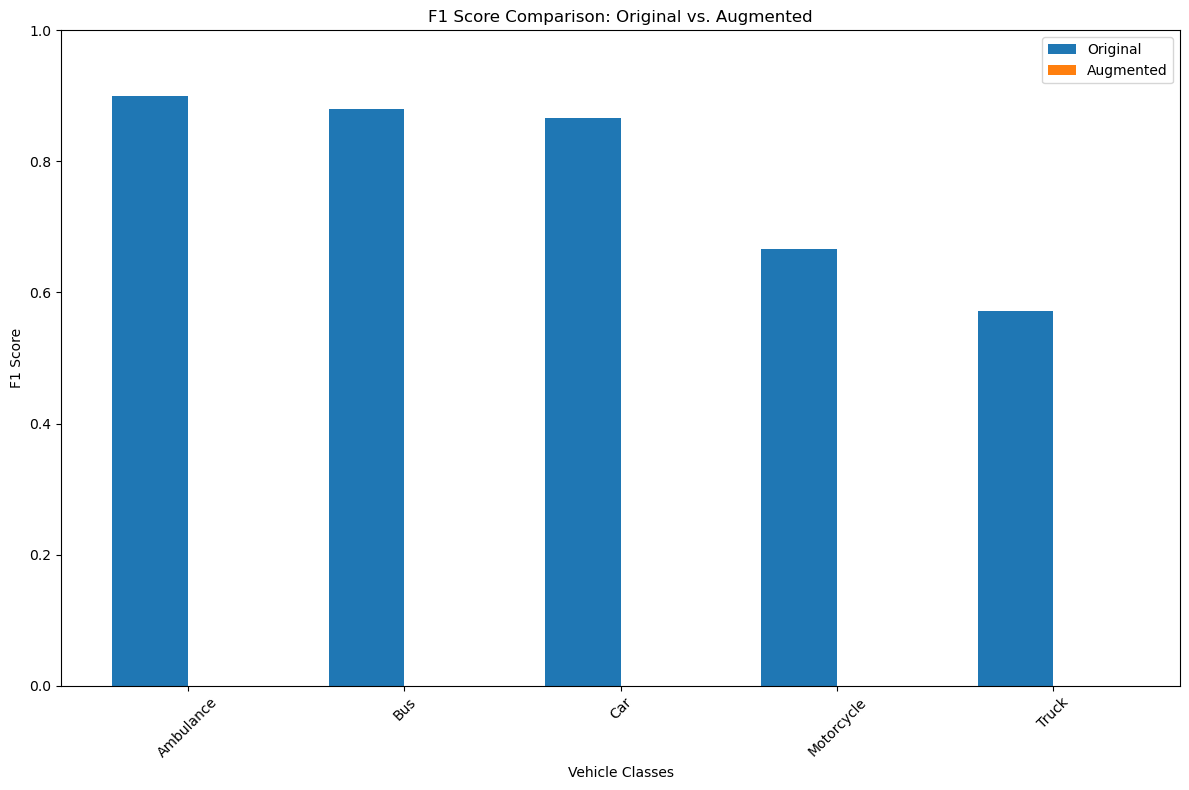

In [ ]:
# Set up the figure and axis for plotting
plt.figure(figsize=(12, 8))

# Bar chart for F1 scores comparison
x = np.arange(len(class_names))
width = 0.35

# Plot F1 scores for original and augmented datasets
original_f1_values = [class_f1[cls] for cls in class_names]
augmented_f1_values = [augmented_class_f1[cls] for cls in class_names]

plt.bar(x - width/2, original_f1_values, width, label='Original')
plt.bar(x + width/2, augmented_f1_values, width, label='Augmented')

plt.xlabel('Vehicle Classes')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison: Original vs. Augmented')
plt.xticks(x, class_names, rotation=45)
plt.ylim(0, 1.0)
plt.legend()
plt.tight_layout()

plt.show()